### Evolving Network Analysis - January 2018
#### <i>Abdel K. Bokharouss, Joris Rombouts, Bart van Helvert, Remco Surtel</i>

### <font color = "green">imports and preparation</font>

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import datetime
import tkinter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [3]:
with open("./data/tgraph_real_wikiedithyperlinks.txt") as file:
    peek = file.readlines()[:10]
peek

['1 6 1028243088 1120917090\n',
 '1 8 1029885647 1136791625\n',
 '1 9 1029885647 1136791625\n',
 '1 3 1028243088 1143227562\n',
 '1 3 1146727453 1148998304\n',
 '1 5 1028243088 1184096745\n',
 '1 2 1028243088 1184096745\n',
 '1 3 1149598035 1184096745\n',
 '1 4 1028243088 1184096745\n',
 '1 7 1028243088 1184096745\n']

In [4]:
temp_nw = pd.read_table("./data/tgraph_real_wikiedithyperlinks.txt", header = None, sep = " ",
                       names = ["src", "trg", "start", "end"])

In [5]:
temp_nw.head()

,src,trg,start,end
0,1,6,1028243088,1120917090
1,1,8,1029885647,1136791625
2,1,9,1029885647,1136791625
3,1,3,1028243088,1143227562
4,1,3,1146727453,1148998304


In [6]:
temp_nw['start'] = pd.to_datetime(temp_nw['start'], unit = 's') #convert Unix timestamps to date time, utc = 0
temp_nw['end'] = pd.to_datetime(temp_nw['end'], unit = 's')

In [7]:
temp_nw.head(10)

,src,trg,start,end
0,1,6,2002-08-01 23:04:48,2005-07-09 13:51:30
1,1,8,2002-08-20 23:20:47,2006-01-09 07:27:05
2,1,9,2002-08-20 23:20:47,2006-01-09 07:27:05
3,1,3,2002-08-01 23:04:48,2006-03-24 19:12:42
4,1,3,2006-05-04 07:24:13,2006-05-30 14:11:44
5,1,5,2002-08-01 23:04:48,2007-07-10 19:45:45
6,1,2,2002-08-01 23:04:48,2007-07-10 19:45:45
7,1,3,2006-06-06 12:47:15,2007-07-10 19:45:45
8,1,4,2002-08-01 23:04:48,2007-07-10 19:45:45
9,1,7,2002-08-01 23:04:48,2007-07-10 19:45:45


In [8]:
print(
    datetime.datetime.fromtimestamp(
        int("1028243088")
    ).strftime('%Y-%m-%d %H:%M:%S')
)

2002-08-02 01:04:48


In [9]:
static_nw = temp_nw.copy()
static_nw.drop(['start', 'end'], axis = 1, inplace = True)
static_nw.head()

,src,trg
0,1,6
1,1,8
2,1,9
3,1,3
4,1,3


In [10]:
static_nw.loc[static_nw['src'] == static_nw['trg']].count()#number of self loops

src    20037
trg    20037
dtype: int64

## Static Network Analysis

In this analysis we ignore the time information of each edge. Therefore, we first create a graph $G_{static}$, based only on the pairs of source node and target node. In this paragraph we treat two measures: clustering coefficient and the largest connected component (LCC) which are measures that are very closely related to each other. When analyzing connectedness and clustering ask ourselves how integrated or fractured the overall network is. We look at how these  major subsystems are distributed out and their local characteristics. A graph is connected if for any node in the graph there is a path to any other node. When a graph is not connected, there will be a number of components to it. A component is a subset of nodes and edges within a that are fully connected. First, we will look at the clusters of this particular network. 

### Clustering coefficient
A cluster is simply a subset of nodes and edges in a graph that posses a certain common characteristics or relate to each other in a particular manner.  So a component is simply referring to whether a given set of nodes are all connected or not. A cluster is referring to how they are connected and how much they are connected. This value is measured as the clustering coefficient of a node. We take a node and look at how connected a node that it links to is to other nodes that it also connceted to. For example, in a social network, we ask how many of your friends know your other friends. The more your friends are interconnected, the more clustered the subset is to be. 

The clustering coefficient captures the ratio of existing links connecting a nodes neighbors to each other relative to the maximum possible number of links that could exist between them. 

The clustering coefficient is trying to capture cliquishness. In other words, the clustering coefficient of a node in a graph quentifies how close its neighbours are to be being a clique. Let $G = (V,E)$ a graph. A clique is a subset of nodes of a graph such that every two distinct nodes in the clique are adjacent. More formal: a clique is a subset $C \subseteq V$ such that $(u,v)$ in $E$ for all pairs $u,v$ in $C$.  In fact, a clique is a complete sub-graph, which means that in a clique, each node has a direct link with each other node.

The clustering coefficient represents the fraction of possible interconnectors between the neighbors of a node $u$. The clustering coefficient is a value between zero and one. The coefficient equals zero, if $u$ is the centere of a "star", where his neighbors are not connected to eachother. When the clustering coefficient is one, we have a clique. This means that $u$ is connected to its neighbors, and all its neighbors are connected to each other. 

Let's have a directed graph $G=(V,E)$, with $V$ nodes and $E$ edges. The neighboorhood $N_i$ for a node $u_i$ is defined as its immediately connected neighbors as follows: 
$$N_i = {u_j : e_{ij} \in E \vee e_{ji} \in E}$$
Let $k_i$ be the number of neighbors of node $u$. For a directed graph, $e_{ij}$ is distinct from $e_{ji}$, and therefore for each neighborhood $N_i$ there are $k_i \cdot k_i -1$ links that could exist among the nodes within the neighborhood. Thus, the clustering coefficient $C_i$ of a node $u_i$ in a unweighted directed graph $G=(V,E)$ is given as:

$$C_i = \frac{| \{  e_{jk} : u_j, u_k \in N_i, e_{jk}\in E \} |}{k_i (k_i - 1)}$$

Before we start analyzing the clustering coefficients of $G_{static}$, we have to create some functions to actually calculate these cluster coefficients. The standard builtin `clustering` algorithm of <i>NetworkX</i> is not implemented for directed graphs. Thanks to the fact that <i>NetworkX</i> is open-source, we can have a look at the underlying source code of the algorithms. With this knowledge, we can create a new function by ourselves to create a function `clustering_directed` returns a dictionary, for each node the corresponding clustering coefficient.

In [48]:
def clustering_directed(G):
    td_iter = nx.cluster._triangles_and_degree_iter(G)
    clusterc = {v: 0 if t == 0 else (t) / (d * (d - 1)) for
                        v, d, t, _ in td_iter}
    return clusterc

To compute the clustering coefficient of the entire graph, we define a new function `average_clustering_directed`. Note that the clustering coefficient of a graph is just the average of the clustering coefficient of all nodes.

In [49]:
def average_clustering_directed(G):
    c = clustering_directed(G).values()
    return sum(c) / len(c)

In [11]:
#np.savetxt(r'./data/tgraph_real_wikiedithyperlinks_NoTime.txt', static_nw.values, fmt='%d')

Now we can start analyzing the directed graph. We first load the graph into a variable $G_{static-directed}$.

In [50]:
fh = open("data/tgraph_real_wikiedithyperlinks_NoTime.txt", 'rb')
G_static_directed = nx.read_edgelist(fh,create_using=nx.DiGraph())
fh.close()

The function `cluster_directed` created above is used for calculating the cluster coefficient for each node. After that we store the results of each node in a dataframe. The dataframe is exported as a csv file, to prevent that we have to run this time-consuming process again.  

In [14]:
#cluster_score_directed = clustering_directed(G_static_directed)

In [52]:
#df_cluster_score_directed = pd.DataFrame(list(cluster_score_directed.items()), columns=['Node', 'Cluster Coefficient'])
df_cluster_score_directed = pd.read_csv('data/cluster_score_directed.csv')
df_cluster_score_directed.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [53]:
df_cluster_score_directed.head()

,Node,Cluster Coefficient
0,1,0.061912
1,6,0.000000
2,8,0.066667
3,9,0.027236
4,3,0.010648


In [54]:
df_cluster_score_directed.sort_values(by=['Cluster Coefficient'], inplace = True, ascending = False)
df_cluster_score_directed.head()

,Node,Cluster Coefficient
561520,760569,1.0
427413,434858,1.0
540805,714919,1.0
598652,571758,1.0
460988,448681,1.0


The most interesting values of the clustering coefficient are $0$ and $1$, i.e. the nodes that have neighbor nodes who are entirely not connected to each other and nodes that have neighbor nodes who are entirely connected. First, we count the nodes who have a cluster coefficient of $1$.

In [55]:
df_cluster_score_directed.loc[df_cluster_score_directed['Cluster Coefficient'] == 1.0].count()#number of nodes with coefficient of 1, i.e. that are a clique

Node                   1873
Cluster Coefficient    1873
dtype: int64

We see that $\frac{1837}{678907} \cdot 100 \text{%} = 0.27$% of the nodes have a cluster coefficient of $1$. So only $0.27$% of the nodes have adjacent nodes that have link between themzelves, in other words, are a clique. In terms of a (social) network this means that these are group of articles all of whom have a link to each other. This is a very low fraction, so we can imagine that in such a large network there are many group of articles all of whom have no link to each other. In the following cell we calculate this number of articles by counting the rows with a value of $0$ for `Cluster Coefficient`.

In [56]:
df_cluster_score_directed.loc[df_cluster_score_directed['Cluster Coefficient'] == 0.0].count()#number of nodes with coefficient of 0, i.e. nodes that are connected to no other (neighbor) nodes

Node                   518053
Cluster Coefficient    518053
dtype: int64

As one can see, $\frac{518053}{678907} \cdot 100 \text{%} = 76$% of the nodes  have no links between the neighbor nodes themselves. This means that more than three quarter of the nodes have neighbor nodes who have no link between them. So these nodes can be considered as the centre of a "star". This means that articles that are linked to the wiki page are in most of the time articles that give some additional information to the wiki page, information that was not on other articles already linked to the wiki page. It makes sense that this is a very high percentage of the node, since we are considering a directed graph. To make the numbers more visual, we plot a histogram of the frequency of the cluster coefficients of the entire graph $G_{static-directed}$.

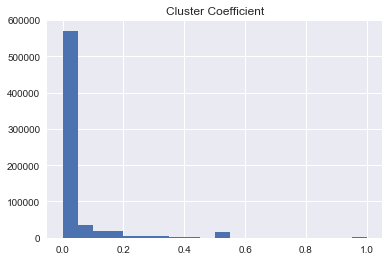

In [57]:
df_cluster_score_directed.hist(column='Cluster Coefficient', bins = 20);
plt.show()

The histogram confirms our statements above. More than three quarter of the nodes in the graph have a cluster coefficient of zero. 

We defined the clustering coefficient of a node in a graph as the proportion of that nodes neighbors that are connected. However, we are also interested in the distribution of the clustering coefficient over the nodes in the network. A network could have for instance some very clustered parts and some less clustered parts, while another network could have many nodes with a similar, average clustering coefficient. So, we want to consider the distribution of clustering coefficient. Below, this distribution is plotted as a cumulated plot. 

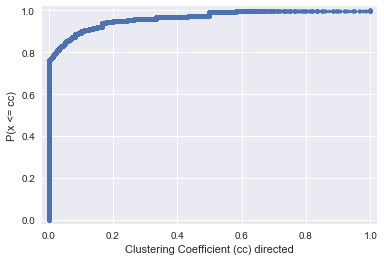

In [58]:
x = np.sort(df_cluster_score_directed['Cluster Coefficient'])
y = np.arange(1, len(x) + 1 )/ len(x)
_ = plt.plot(x,y, marker=".", linestyle = 'none')
_ = plt.xlabel('Clustering Coefficient (cc) directed')
_ = plt.ylabel('P(x <= cc)')
plt.margins(0.02) #keeps data off plot edges (i.e. 2% buffer all around the plot)
plt.show()

The y-value is the fraction of data points that have a value smaller than the corresponding x-value. For example, 78% of the nodes have a cluster coefficient of 0.1 (or less). Similarly, around 90% of the nodes have a cluster coefficient of 0.2 (or less). We see that slope of the plot decreases over time, which means that there are a lot of nodes with a very small cluster coefficient, compared to nodes with a high cluster coefficient. This is also what we concluded from the histogram above and the ECDF plot confirms this.

For readability, we can exclude the nodes with a cluster coefficient of zero, to get a better look of the other nodes in the graph.

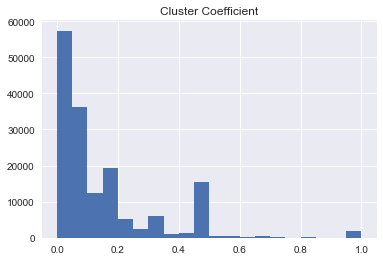

In [64]:
df_cluster_score_directed_large = df_cluster_score_directed.loc[df_cluster_score_directed['Cluster Coefficient'] != 0.0]
df_cluster_score_directed_large.hist(column='Cluster Coefficient', bins = 20);
plt.show()

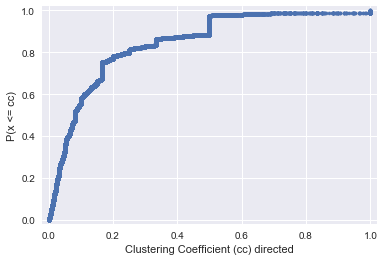

In [65]:
x = np.sort(df_cluster_score_directed_large['Cluster Coefficient'])
y = np.arange(1, len(x) + 1 )/ len(x)
_ = plt.plot(x,y, marker=".", linestyle = 'none')
_ = plt.xlabel('Clustering Coefficient (cc) directed')
_ = plt.ylabel('P(x <= cc)')
plt.margins(0.02) #keeps data off plot edges (i.e. 2% buffer all around the plot)
plt.show()

The ECDF shows us that, for example, around 50% of all the non-zero cluster coefficient nodes have a cluster coefficient of 0.1 (or less). We see that more around 90% of the non-zero cluster coefficient nodes have a cluster coefficient of 0.5 or less. This is also what we concluded from the histogram above and the ECDF plot confirms this. This means that the clusters in the graph are not highly connected. When we take this into perspective of the wiki-page, there are a lot of articles where the neighbors are not highly connected. This means that these website don't link to each other, so there might be new information on it, because otherwise it is not added to the wiki page. 

Back to the original $G_{static-directed}$ graph, including all the nodes. Another interesting statistic about the graph is the clustering coefficient of the entire graph, instead of each node. Recall that the clustering coefficient of a graph is just the average of the clustering coefficient of all nodes. We use this statistic in future analysis for comparison. 

In [69]:
avg_cluster_score_directed = average_clustering_directed(G_static_directed)

In [70]:
avg_cluster_score_directed

0.03677470061413527

Average cluster coefficient score complete graph: $0.037$. We save this value in a variable so that we don't have to run this time consuming cell again.

### Largest connected component (LCC)

The number of components says something about how a network is fractioned. Before we check for the largest connected component, we first check how many connected components there are in this network. 

In [23]:
number_of_connected_components = nx.number_connected_components(G_static)
number_of_connected_components

6324

The network contains $6324$ connected components, which is quite a lot. One can image that the network looks like a fractioned network because of this. To conclude this, we will calculate how many of these connected components consist of only one single edge (two nodes) and the difference between the smallest connected component of length greater than one and the largest connected component. We run `connected_component_subgraphs()` algorithm of the <i>NetworkX library</i>. This algorithm generates a set of nodes, one for each component in the graph. Finding all the connected component for an undirected is easy, because we can simply run the wel known  `breadth first search` algorithm starting from every unvisited node to get all connected components. This is exactly what the `connected_component_subgraphs()` of <i>NetworkX</i> does. All the $6324$ connected components are written to a <i>.edgelist</i>, so that we only have to run this, very time consuming algorithm, once. 

In [24]:
#list_connected_components = list(nx.connected_component_subgraphs(G_static))

In [25]:
#for i in range(0, len(list_connected_components)):
#    list_component = list_connected_components[i]
#    nx.write_edgelist(list_component, "subgraphs/list_connected_components"+str(i)+".edgelist", data=False)

To count how many of these connected components are of size one, two, etc. we open each graph file which we just created and check the length of the graph compared to some integer. The function below is executed for <i>length</i> <u>strictly larger </u> than $0,...,19$. The results are summarized in a table below.

In [26]:
def check_size_components(length):
    count = 0
    for i in range(0, number_of_connected_components):
        fh = open("subgraphs/list_connected_components"+str(i)+".edgelist", 'rb')
        G_component = nx.read_edgelist(fh,create_using=nx.Graph())
        fh.close()
        if len(G_component) > length:
            count +=1
            #print("subgraphs/list_connected_components"+str(i)+".edgelist")
    return count

In [27]:
length = 100 #execute this cell for length = 0,...,19
check_size_components(length)

1

| Connected component size, strictly larger than: | number of components   |
|------|------|
|   0  | 6324|
|1|4937|
|2|855|
|3|267|
|4|112|
|5|56|
|6|33|
|7|20|
|8|15|
|9|12|
|10|8|
|...|...|
|19|3|

We see that there are $6324 - 4937 = 1387$ components consisting of only one edge (i.e. two nodes) . Also, there is a large decrease in number of compoonents between the second and third entry. There are $4937-855 = 4082$ components consisting of only two edges. Almost two third of the total components have just two edges, so we can conclude that there are a lot of small components in this network. We see that there are only 3 components that have more than 19 edges in the component. These are the dominating components of the graph. To get the largest connected component, we can call the `max`-operator on `list_connected_component`, but because this is a very time consuming algorithm on such a large network with so many edges, we call `check_size_components`, parameterized with length=100. 

In [28]:
length = 100 #execute this cell for length = 0,...,19
check_size_components(length)

1

So there is only one connected component with more than 100 number of edges in it. This connected component is the largest connected component of $G_{static}$. To get more information about this largest connected component, we load <i>list_connected_components0.edgelist</i> into a variable <i>largest_cc</i>.

In [29]:
fh = open("subgraphs/list_connected_components0.edgelist", 'rb')
largest_cc = nx.read_edgelist(fh,create_using=nx.Graph())
fh.close()

In [30]:
len(largest_cc)

666195

We see that the largest connected component consist of $666195$ edges, so this is very large compared to the second, third, etc. connected components. Because the graph is loaded as an undirected graph, it makes sense that there is a large connected component. Almost every page linked to the wiki page, also has an incoming or outcoming edge inside the domain (wiki-page in this case). Because the largest connected component is of such large size, it might be interesting to plot the other top five largest connected components of $G_static$ to take a quick look at their structure. The remaining top-5 of largest connected components (besides the largest connected component itself) are the following files, sorted from largest to smallest:
* <i>list_connected_components3587.edgelist</i>
* <i>list_connected_components3001.edgelist</i>
* <i>list_connected_components2684.edgelist</i>
* <i>list_connected_components253.edgelist</i>

We will plot each of these connected components to find something interesting.

#### Second largest component

In [3]:
fh = open("subgraphs/list_connected_components3587.edgelist", 'rb')
second_largest_cc = nx.read_edgelist(fh,create_using=nx.DiGraph())
fh.close()

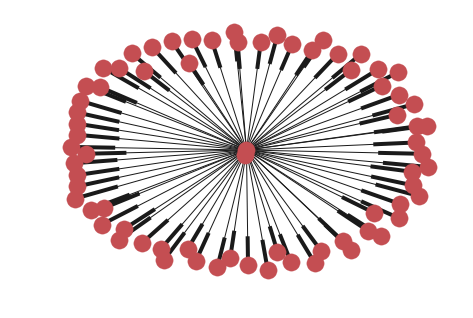

In [4]:
nx.draw(second_largest_cc);
plt.show()

#### Third largest component

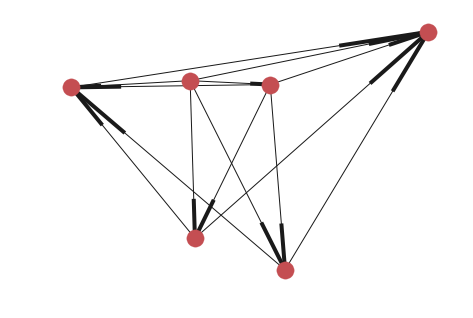

In [5]:
fh = open("subgraphs/list_connected_components3001.edgelist", 'rb')
third_largest_cc = nx.read_edgelist(fh,create_using=nx.DiGraph())
fh.close()
nx.draw(third_largest_cc);
plt.show()

#### Fourth largest component

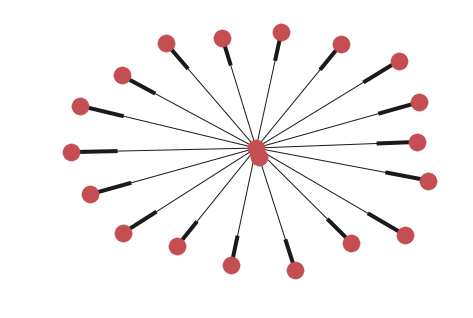

In [6]:
fh = open("subgraphs/list_connected_components2684.edgelist", 'rb')
fourth_largest_cc = nx.read_edgelist(fh,create_using=nx.DiGraph())
fh.close()
nx.draw(fourth_largest_cc);
plt.show()

#### Fifth largest component

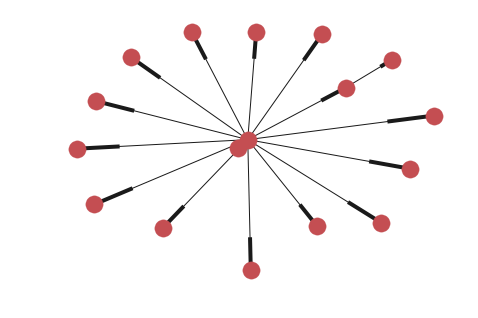

In [7]:
fh = open("subgraphs/list_connected_components253.edgelist", 'rb')
fifth_largest_cc = nx.read_edgelist(fh,create_using=nx.DiGraph())
fh.close()
nx.draw(fifth_largest_cc);
plt.show()

We see that the remaining top four largest connected component have one thing in common. Three of the top four largest connected components are a star. We have seen in the previous paragraph that the centre node of the star have a clustering coefficient of 0, because the adjacent nodes of the centre node have no links betweem themselves. We see that the clustering coefficient and largest connected component(s) are indeed related. To check are assumptions, we run the clustering coefficient algorithm of <i>NetworkX</i> on the top five connected components. 

In [36]:
#cluster_score_largest = nx.average_clustering(largest_cc)
#cluster_score_largest

In [37]:
cluster_score_second = nx.average_clustering(second_largest_cc)
cluster_score_second

0.0

In [38]:
cluster_score_third = nx.average_clustering(third_largest_cc)
cluster_score_third

0.9333333333333335

In [39]:
cluster_score_fourth = nx.average_clustering(fourth_largest_cc)
cluster_score_fourth

0.0

In [40]:
cluster_score_fifth = nx.average_clustering(fifth_largest_cc)
cluster_score_fifth

0.0

The results above indeed confirms our hypotheses. The connected components that are a star have an average clustering coefficient of 0. The largest connected component has an average clustering coefficient of $0.116$, which is almost equal to the the average clustering coefficient of the whole graph $G_{static}$. This means that the largest connected is very minimal connected, just as the original graph $G_{static}$. The average clustering coefficient is closer to zero then to one, so although it is a connected component, the nodes are not very high connected between themselves.

This equals the diameter that is calculated in the paragraph which treats the diameter measure, as we expected. Earlier, we showed a table where the size of a number of connected components is calculated. To get a deeper insight into these numbers, we store the numbers in a dataframe. This dataframe is exported to a csv file, so that we only have to read this file when we want to use it later. $df_{cc}$ contains the number of edges in the connected component, so that we can see the sizes of the components.

In [42]:
#cc = { 'Number of components': [check_size_components(i) for i in range(0,19)], 'Connected component size, strictly larger than': [i for i in range(0,19)]}
#df_cc = pd.DataFrame(data=cc)

In [43]:
#df_cc.to_csv('data/df_cc.csv')

In [69]:
df_cc = pd.read_csv('data/df_cc.csv')
df_cc.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [70]:
df_cc.head(20)

,"Connected component size, strictly larger than",Number of components
0,0,6324
1,1,4937
2,2,855
3,3,267
4,4,112
5,5,56
6,6,33
7,7,20
8,8,15
9,9,12


The numbers in this table are analyzed before. To make a visual representation, we plot a histogram and a ECDF in the cells below. 

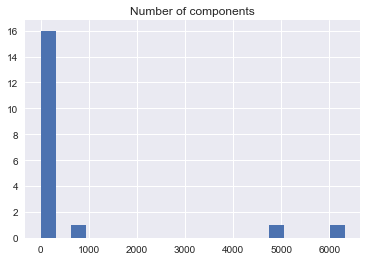

In [71]:
df_cc.hist(column='Number of components', bins = 20);
plt.show()

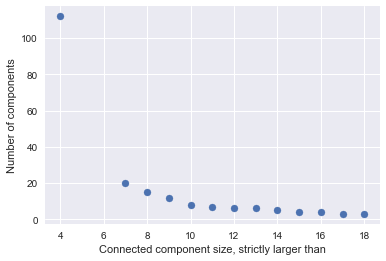

In [83]:
df_cc = df_cc.drop(df_cc.index[[0,2]])
plt.scatter(df_cc['Connected component size, strictly larger than'], df_cc['Number of components'])
_ = plt.xlabel('Connected component size, strictly larger than')
_ = plt.ylabel('Number of components')
plt.show()

Excluding the top two outliers (first two rows of the dataframe), we see that the larger we set the minimum size of edges in the component, the less components satisfy that boundary. This means that we only have a few large connected components in the static network. We also saw that there was one connected network, that had a gigantic size compared to the rest. This is probably because links that are added or removed, already were part of the wiki link data, because they were linked by some other pages. So the links are in most of the time picked from the same network domain. This makes sense, because new links are in most of the time on the same topic and therefore already were linked by some other articles. 